In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from matplotlib.dates import DayLocator, DateFormatter, date2num
from matplotlib.ticker import FuncFormatter
from matplotlib import rc
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet
import chart_studio
import chart_studio.plotly as py

In [2]:
chart_studio.tools.set_credentials_file(username='ralhusban', api_key='0F7vaylJaEkkbwUk3SLi')
chart_studio.tools.set_config_file(world_readable=True,
                             sharing='public')

In [3]:
import dash
import dash_core_components as dcc
import dash_html_components as html

## Import dataset from the Government of Ontario
The advantage of importing a dataset directly from a URL is that you'll always get an up to date infromation on COVID-19

In [4]:
Ontario_data=pd.read_csv('https://data.ontario.ca/dataset/f4f86e54-872d-43f8-8a86-3892fd3cb5e6/resource/ed270bb8-340b-41f9-a7c6-e8ef587e6d11/download/covidtesting.csv', parse_dates=True)
Ontario_clinic_data=pd.read_csv('https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv', parse_dates=True)

In [5]:
Ontario_confirmed_df=Ontario_data

In [6]:
Ontario_confirmed_df.index=Ontario_confirmed_df['Reported Date'] # Making the date our index to facilitate working with the dataset as a time series

In [7]:
Ontario_confirmed_df.rename(columns={'Total Cases':'Cumulative_cases', 'Deaths':'Cumulative_deaths'}, inplace=True) # Making sure there are no spaces in column names

In [8]:
Ontario_confirmed_df.index=pd.to_datetime(Ontario_confirmed_df.index) # Converting Dtype to Date

In [9]:
Ontario_confirmed_df['New_cases']=Ontario_confirmed_df['Cumulative_cases'].diff() #Diff() calculates difference from previous rows
Ontario_confirmed_df['New_deaths']=Ontario_confirmed_df['Cumulative_deaths'].diff()

## Below we calculate 3-day and 7-day rolling averages which are important metrics in epidemiology. They absorb daily fluctuations in daily numbers and show the general trend

In [10]:
Ontario_confirmed_df['New_cases_MA3']=Ontario_confirmed_df['New_cases'].rolling(window=3).mean()
Ontario_confirmed_df['New_cases_MA7']=Ontario_confirmed_df['New_cases'].rolling(window=7).mean()
Ontario_confirmed_df['New_deaths_MA3']=Ontario_confirmed_df['New_deaths'].rolling(window=3).mean()
Ontario_confirmed_df['New_deaths_MA7']=Ontario_confirmed_df['New_deaths'].rolling(window=7).mean()
Ontario_confirmed_df['Hosp_MA3']=Ontario_confirmed_df['Number of patients hospitalized with COVID-19'].rolling(window=3).mean()
Ontario_confirmed_df['ICU_MA3']=Ontario_confirmed_df['Number of patients in ICU with COVID-19'].rolling(window=3).mean()
Ontario_confirmed_df['Ventilator_MA3']=Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'].rolling(window=3).mean()

In [11]:
Ontario_confirmed_df=Ontario_confirmed_df.iloc[28:] # The first 28 days have little useful data as cases were very low

In [12]:
Ontario_confirmed_df

Reported Date  Confirmed Negative  Presumptive Negative  \
Reported Date                                                           
2020-03-05       2020-03-05              1466.0                   NaN   
2020-03-06       2020-03-06              1665.0                   NaN   
2020-03-07       2020-03-07              1918.0                   NaN   
2020-03-08       2020-03-08              2094.0                   NaN   
2020-03-09       2020-03-09              2347.0                   NaN   
...                     ...                 ...                   ...   
2020-10-24       2020-10-24                 NaN                   NaN   
2020-10-25       2020-10-25                 NaN                   NaN   
2020-10-26       2020-10-26                 NaN                   NaN   
2020-10-27       2020-10-27                 NaN                   NaN   
2020-10-28       2020-10-28                 NaN                   NaN   

               Presumptive Positive  Confirmed Positive  Resolved  \
Reported Date                                                       
2020-03-05                      NaN                18.0       4.0   
2020-03-06                      NaN                22.0       4.0   
2020-03-07                      NaN                24.0       4.0   
2020-03-08                      NaN                25.0       4.0   
2020-03-09                      NaN                31.0       4.0   
...                             ...                 ...       ...   
2020-10-24                      NaN              6821.0   59424.0   
2020-10-25                      NaN              7120.0   60160.0   
2020-10-26                      NaN              7286.0   60839.0   
2020-10-27                      NaN              7418.0   61530.0   
2020-10-28                      NaN              7474.0   62303.0   

               Cumulative_deaths  Cumulative_cases  \
Reported Date                                        
2020-03-05                   NaN              22.0   
2020-03-06                   NaN              26.0   
2020-03-07                   NaN              28.0   
2020-03-08                   NaN              29.0   
2020-03-09                   NaN              35.0   
...                          ...               ...   
2020-10-24                3086.0           69331.0   
2020-10-25                3093.0           70373.0   
2020-10-26                3099.0           71224.0   
2020-10-27                3103.0           72051.0   
2020-10-28                3108.0           72885.0   

               Total patients approved for testing as of Reporting Date  \
Reported Date                                                             
2020-03-05                                                1566.0          
2020-03-06                                                1763.0          
2020-03-07                                                1982.0          
2020-03-08                                                2178.0          
2020-03-09                                                2404.0          
...                                                          ...          
2020-10-24                                             4870002.0          
2020-10-25                                             4908771.0          
2020-10-26                                             4937423.0          
2020-10-27                                             4961368.0          
2020-10-28                                             4991378.0          

               Total tests completed in the last day  ...  \
Reported Date                                         ...   
2020-03-05                                       NaN  ...   
2020-03-06                                       NaN  ...   
2020-03-07                                       NaN  ...   
2020-03-08                                       NaN  ...   
2020-03-09                                       NaN  ...   
...                                              ...  ...   

## Below plot with MATPLOTLIB for hospitalization in Ontario. Note how we define text position using date to set the X axis and the number of cases to set the Y-axis

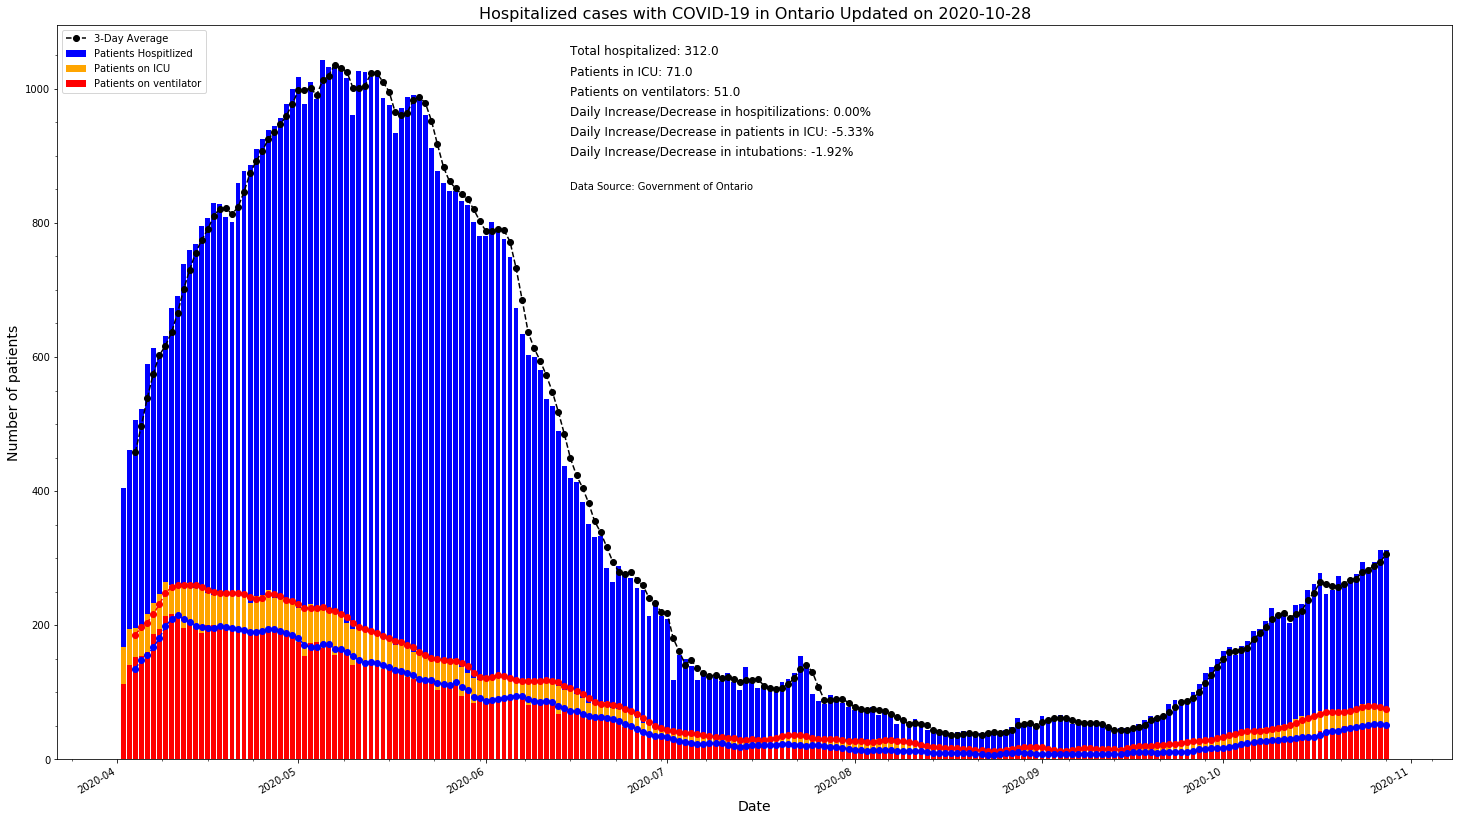

In [13]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients hospitalized with COVID-19'], label='Patients Hospitlized', color='blue')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Hosp_MA3'], 'ko--', label='3-Day Average')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients in ICU with COVID-19'], label='Patients on ICU', color='orange')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['ICU_MA3'], 'ro--')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'], label='Patients on ventilator', color='red')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Ventilator_MA3'], 'bo--')
ax.text(x=dt.datetime(2020,6,15), y=1050,s='Total hospitalized: '+str(Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=1020,s='Patients in ICU: '+str(Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=990,s='Patients on ventilators: '+str(Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-1]), fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=960,s='Daily Increase/Decrease in hospitilizations: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-1]-Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-2])/Ontario_confirmed_df['Number of patients hospitalized with COVID-19'][-2]*100))+'%', fontsize=12) # Note the use of the format() method to round the percentage decimals
ax.text(x=dt.datetime(2020,6,15), y=930,s='Daily Increase/Decrease in patients in ICU: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-1]-Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-2])/Ontario_confirmed_df['Number of patients in ICU with COVID-19'][-2]*100))+'%', fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=900,s='Daily Increase/Decrease in intubations: '+'{0:.2f}'.format(((Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-1]-Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-2])/Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'][-2]*100))+'%', fontsize=12)
ax.text(x=dt.datetime(2020,6,15), y=850,s='Data Source: Government of Ontario')
plt.legend(loc='upper left')
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of patients', fontsize=14)
plt.title('Hospitalized cases with COVID-19 in Ontario Updated on '+ str(dt.date.today()) , fontsize=16)
plt.minorticks_on()
plt.show()

## Testing data is an important metric for any Governmen to detect infection propagation trends. As done previously, note the various metrics generated in the plot

In [14]:
ON_testing_goal_met=0
for i in range(len(Ontario_confirmed_df)):
    if Ontario_confirmed_df['Total tests completed in the last day'][i]>16000:
        ON_testing_goal_met+=1

In [15]:
ON_testing_goal_met

159

In [16]:
ON_days_under_100_cases=0
for i in range(len(Ontario_confirmed_df)):
    if Ontario_confirmed_df['New_cases'][i]<100:
        ON_days_under_100_cases+=1

In [17]:
ON_days_under_100_cases

37

In [18]:
Ontario_confirmed_df

Reported Date  Confirmed Negative  Presumptive Negative  \
Reported Date                                                           
2020-03-05       2020-03-05              1466.0                   NaN   
2020-03-06       2020-03-06              1665.0                   NaN   
2020-03-07       2020-03-07              1918.0                   NaN   
2020-03-08       2020-03-08              2094.0                   NaN   
2020-03-09       2020-03-09              2347.0                   NaN   
...                     ...                 ...                   ...   
2020-10-24       2020-10-24                 NaN                   NaN   
2020-10-25       2020-10-25                 NaN                   NaN   
2020-10-26       2020-10-26                 NaN                   NaN   
2020-10-27       2020-10-27                 NaN                   NaN   
2020-10-28       2020-10-28                 NaN                   NaN   

               Presumptive Positive  Confirmed Positive  Resolved  \
Reported Date                                                       
2020-03-05                      NaN                18.0       4.0   
2020-03-06                      NaN                22.0       4.0   
2020-03-07                      NaN                24.0       4.0   
2020-03-08                      NaN                25.0       4.0   
2020-03-09                      NaN                31.0       4.0   
...                             ...                 ...       ...   
2020-10-24                      NaN              6821.0   59424.0   
2020-10-25                      NaN              7120.0   60160.0   
2020-10-26                      NaN              7286.0   60839.0   
2020-10-27                      NaN              7418.0   61530.0   
2020-10-28                      NaN              7474.0   62303.0   

               Cumulative_deaths  Cumulative_cases  \
Reported Date                                        
2020-03-05                   NaN              22.0   
2020-03-06                   NaN              26.0   
2020-03-07                   NaN              28.0   
2020-03-08                   NaN              29.0   
2020-03-09                   NaN              35.0   
...                          ...               ...   
2020-10-24                3086.0           69331.0   
2020-10-25                3093.0           70373.0   
2020-10-26                3099.0           71224.0   
2020-10-27                3103.0           72051.0   
2020-10-28                3108.0           72885.0   

               Total patients approved for testing as of Reporting Date  \
Reported Date                                                             
2020-03-05                                                1566.0          
2020-03-06                                                1763.0          
2020-03-07                                                1982.0          
2020-03-08                                                2178.0          
2020-03-09                                                2404.0          
...                                                          ...          
2020-10-24                                             4870002.0          
2020-10-25                                             4908771.0          
2020-10-26                                             4937423.0          
2020-10-27                                             4961368.0          
2020-10-28                                             4991378.0          

               Total tests completed in the last day  ...  \
Reported Date                                         ...   
2020-03-05                                       NaN  ...   
2020-03-06                                       NaN  ...   
2020-03-07                                       NaN  ...   
2020-03-08                                       NaN  ...   
2020-03-09                                       NaN  ...   
...                                              ...  ...   

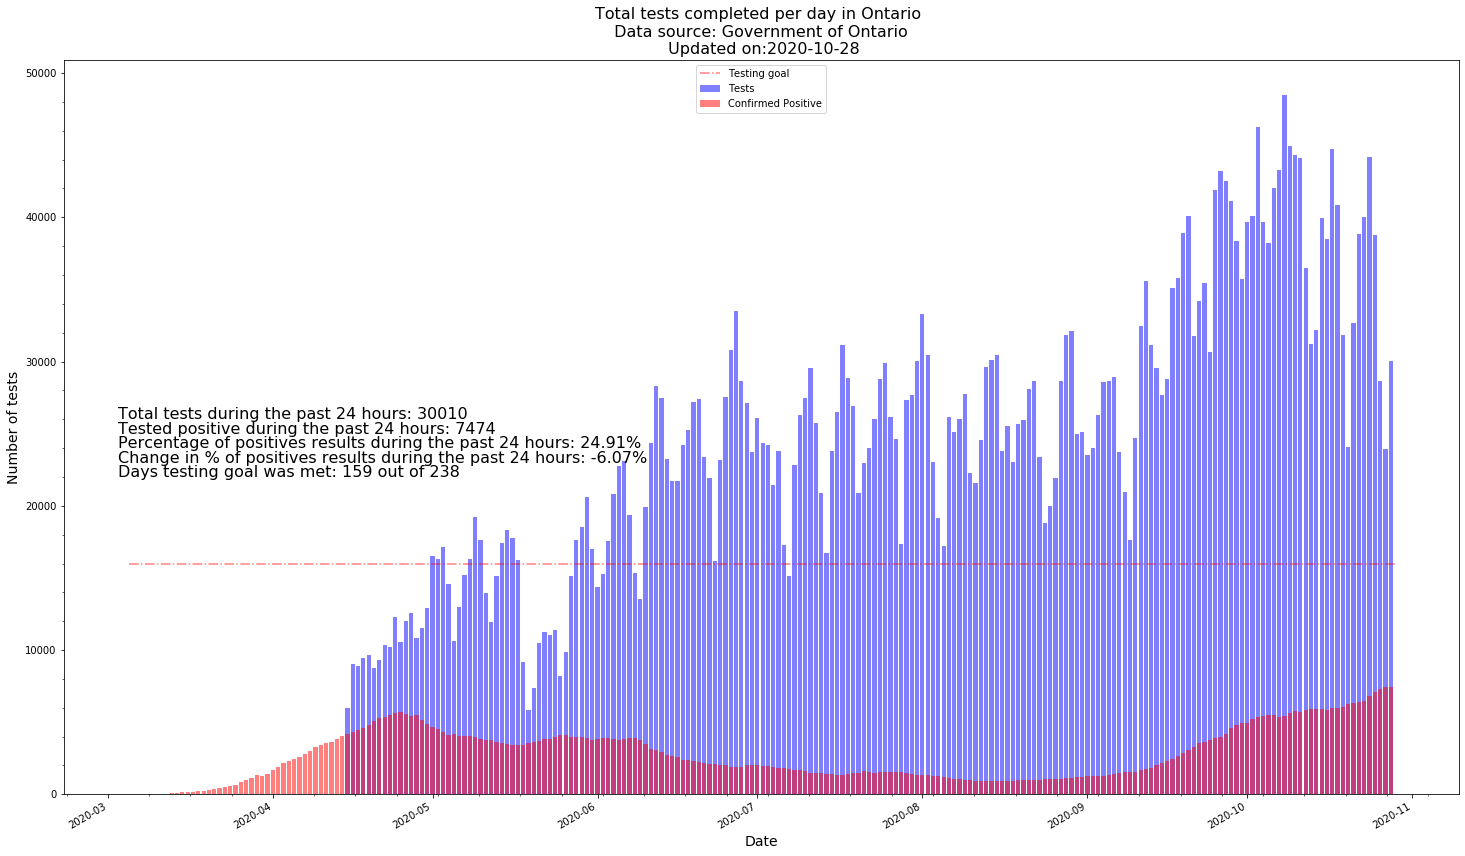

In [19]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Total tests completed in the last day'], label='Tests', color='blue', alpha=0.5)
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Confirmed Positive'], label='Confirmed Positive', color='red', alpha=0.5)
ax.text(x=dt.datetime(2020,3,3), y=26000,s='Total tests during the past 24 hours: '+'{0:.0f}'.format(((Ontario_confirmed_df['Total tests completed in the last day'][-1]))), fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=25000,s='Tested positive during the past 24 hours: '+'{0:.0f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]))), fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=24000,s='Percentage of positives results during the past 24 hours: '+'{0:.2f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]/Ontario_confirmed_df['Total tests completed in the last day'][-1]))*100)+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=23000,s='Change in % of positives results during the past 24 hours: '+'{0:.2f}'.format(((Ontario_confirmed_df['Confirmed Positive'][-1]/Ontario_confirmed_df['Total tests completed in the last day'][-1])-(Ontario_confirmed_df['Confirmed Positive'][-2]/Ontario_confirmed_df['Total tests completed in the last day'][-2]))*100)+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,3), y=22000,s='Days testing goal was met: '+str(ON_testing_goal_met)+' out of '+str(len(Ontario_confirmed_df)), fontsize=16)
#ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df['Confirmed Negative'], label='Confirmed Negative', color='red', alpha=0.3)
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of tests', fontsize=14)
plt.title('Total tests completed per day in Ontario \n Data source: Government of Ontario \n Updated on:'+str(dt.date.today()), fontsize=16)
plt.minorticks_on()
plt.hlines(16000, dt.datetime(2020,3,5), dt.datetime.today(), color='red', label='Testing goal', linestyles='dashdot', alpha=0.5) #Displaying a horizontal dash line across the graph
plt.legend(loc='upper center')

plt.show()

## Plotting cumulative, active, and resolved cases in Ontario
## Note that active cases are calculated as Cumulative cases - resolved cases - deaths

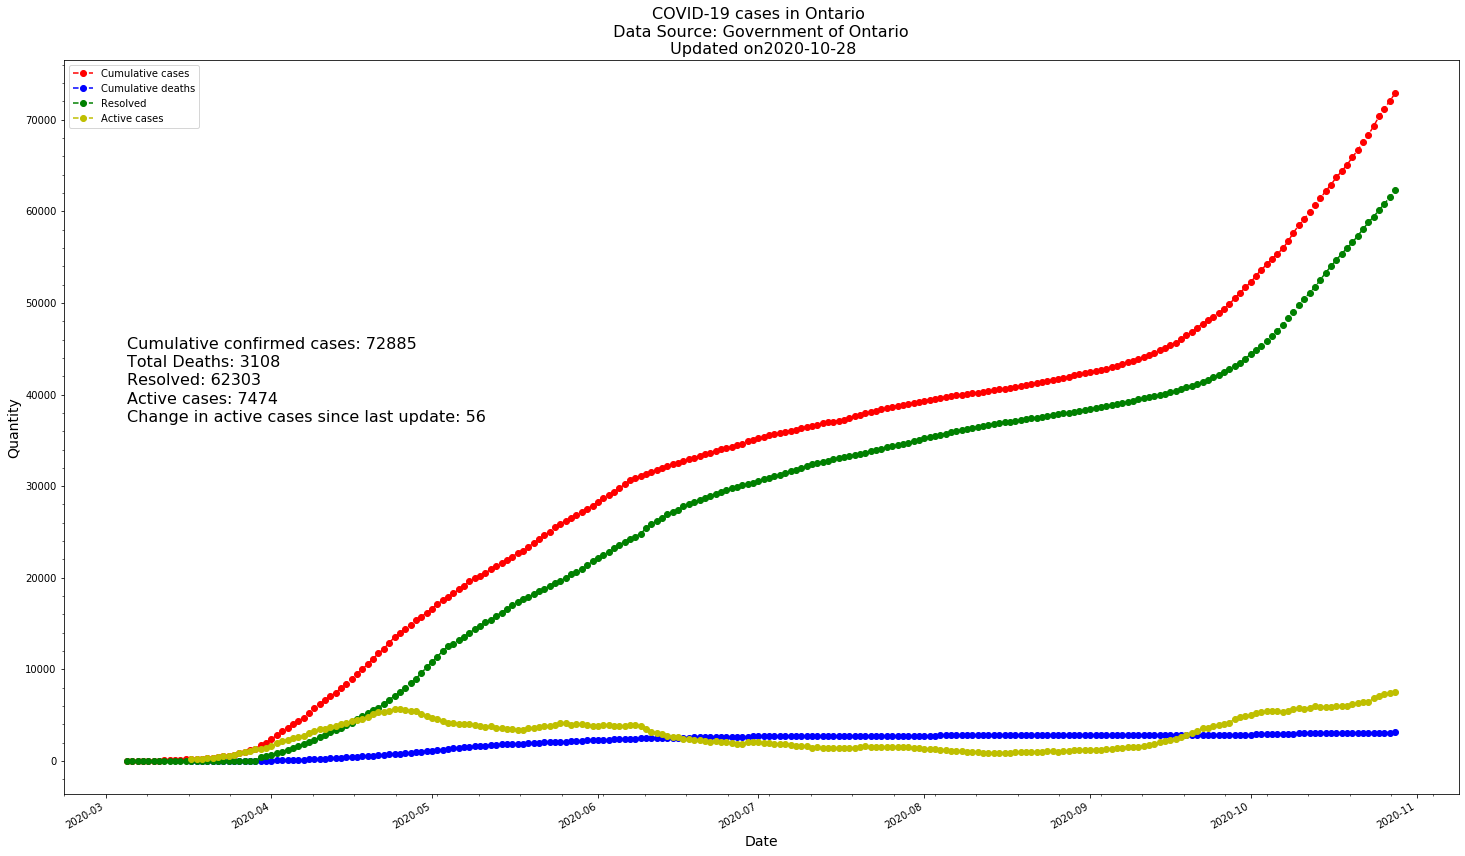

In [20]:
fig, ax=plt.subplots(figsize=(25,15))
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_cases, 'ro--', label='Cumulative cases')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_deaths, 'bo--', label='Cumulative deaths')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df['Resolved'],  'go--', label='Resolved')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.Cumulative_cases-Ontario_confirmed_df['Resolved']-Ontario_confirmed_df.Cumulative_deaths, 'yo--', label='Active cases')
ax.text(x=dt.datetime(2020,3,5), y=45000,s='Cumulative confirmed cases: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=43000,s='Total Deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=41000,s='Resolved: '+str('{0:.0f}'.format(Ontario_confirmed_df.Resolved[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=39000,s='Active cases: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1]-Ontario_confirmed_df['Resolved'][-1]-Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=37000,s='Change in active cases since last update: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1]-Ontario_confirmed_df['Resolved'][-1]-Ontario_confirmed_df.Cumulative_deaths[-1]-Ontario_confirmed_df.Cumulative_cases[-2]+Ontario_confirmed_df['Resolved'][-2]+Ontario_confirmed_df.Cumulative_deaths[-2])), fontsize=16)
plt.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.title('COVID-19 cases in Ontario \n Data Source: Government of Ontario \n Updated on'+str(dt.date.today()), fontsize=16)
plt.minorticks_on()
#plt.grid(which='major')
plt.show()

## We plot the daily new cases of infections and deaths in Ontario Province using matplotlib. In order to metigate day-to-day fluctuations, the blue line tracks a 7-days rolling average of new infections to show a more general trend of the 'curve' which appears to be on the downward trend since April 15. A few texts combined with variables are also plotted on the chart to reflect important changes such as change in new infections and deaths. 


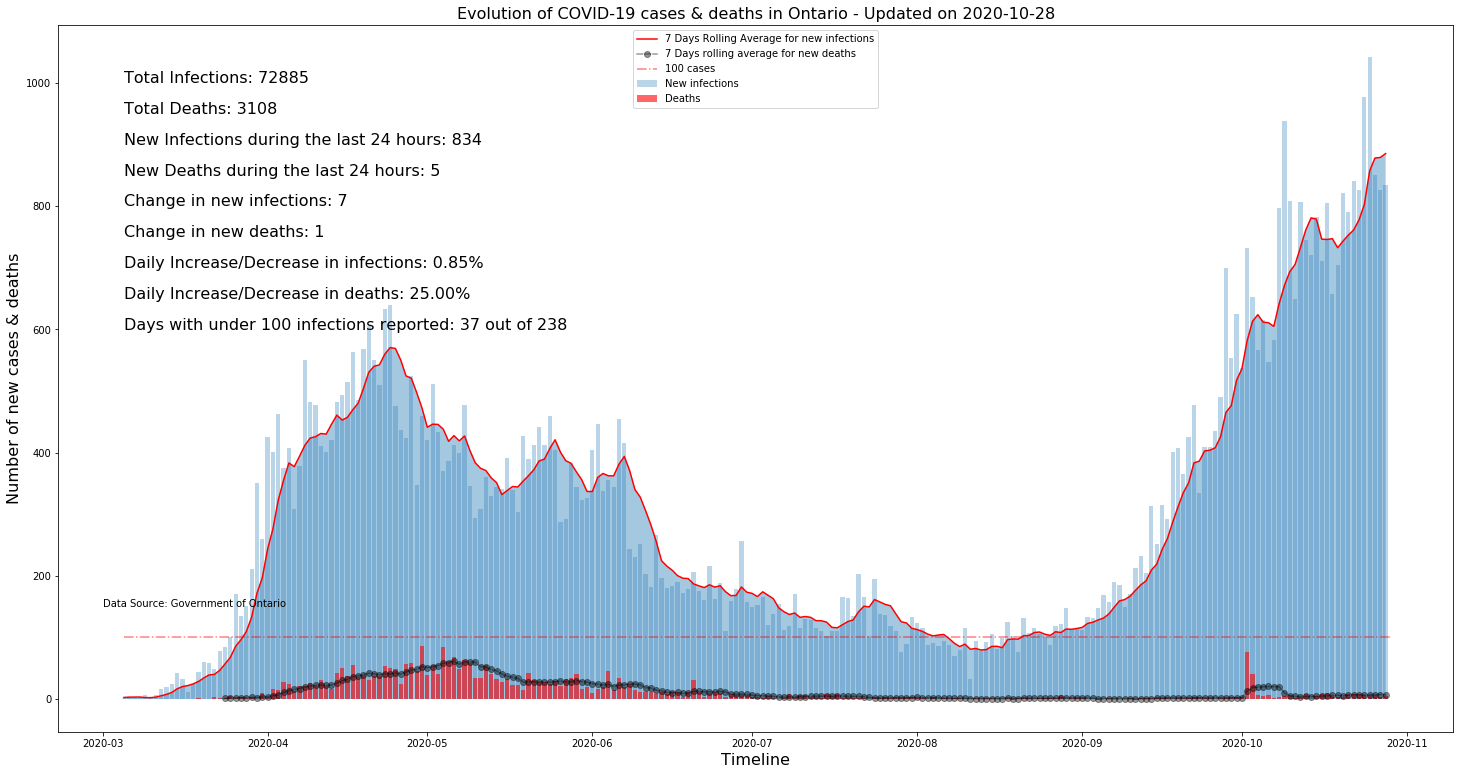

In [21]:
#pd.date_range(start='2020-01-22', periods=len(Ontario_confirmed_df), freq='D')
fig, ax=plt.subplots(figsize=(25,13))
ax.xaxis_date()
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases, alpha=0.3, label='New infections')
ax.bar(Ontario_confirmed_df.index, Ontario_confirmed_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.stackplot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases_MA7, labels=[], alpha=0.4 )
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_cases_MA7, color='red', label= '7 Days Rolling Average for new infections')
ax.plot(Ontario_confirmed_df.index, Ontario_confirmed_df.New_deaths_MA7, 'ko--', dash_capstyle='projecting', alpha=0.4, label='7 Days rolling average for new deaths' )
ax.text(x=dt.datetime(2020,3,5), y=1000,s='Total Infections: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=950,s='Total Deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.Cumulative_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=900,s='New Infections during the last 24 hours: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_cases[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=850,s='New Deaths during the last 24 hours: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_deaths[-1])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=800,s='Change in new infections: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_cases[-1]-Ontario_confirmed_df.New_cases[-2])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=750,s='Change in new deaths: '+str('{0:.0f}'.format(Ontario_confirmed_df.New_deaths[-1]-Ontario_confirmed_df.New_deaths[-2])), fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=700,s='Daily Increase/Decrease in infections: '+'{0:.2f}'.format(((Ontario_confirmed_df.New_cases[-1]-Ontario_confirmed_df.New_cases[-2])/Ontario_confirmed_df.New_cases[-2]*100))+'%', fontsize=16) # Note the use of the format() method to round the percentage decimals
ax.text(x=dt.datetime(2020,3,5), y=650,s='Daily Increase/Decrease in deaths: '+'{0:.2f}'.format(((Ontario_confirmed_df.New_deaths[-1]-Ontario_confirmed_df.New_deaths[-2])/Ontario_confirmed_df.New_deaths[-2]*100))+'%', fontsize=16)
ax.text(x=dt.datetime(2020,3,5), y=600,s='Days with under 100 infections reported: '+str(ON_days_under_100_cases)+' out of '+str(len(Ontario_confirmed_df)), fontsize=16)
ax.text(x=dt.datetime(2020,3,1), y=150,s='Data Source: Government of Ontario')
#fig.autofmt_xdate()
#ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
#ax.fmt_xdata = mdates.date_ticker_factory()
#plt.tight_layout()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.hlines(100, dt.datetime(2020,3,5), dt.datetime.today(), color='red', label='100 cases', linestyles='dashdot', alpha=0.5) #Displaying a horizontal dash line across the graph
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in Ontario - Updated on '+str(dt.date.today()), fontsize=16)
plt.savefig('COVID19ON.pdf', bbox_inches='tight') # This code saves the plot to a PDF file
plt.show()

## The below chart is generated with Plotly Express library, with a main advantage that it's an interactive chart and easy to generate mainly inteded for tidy date! Just hover the mouse over the chart and you will be able to read the details of each day & many other functions!

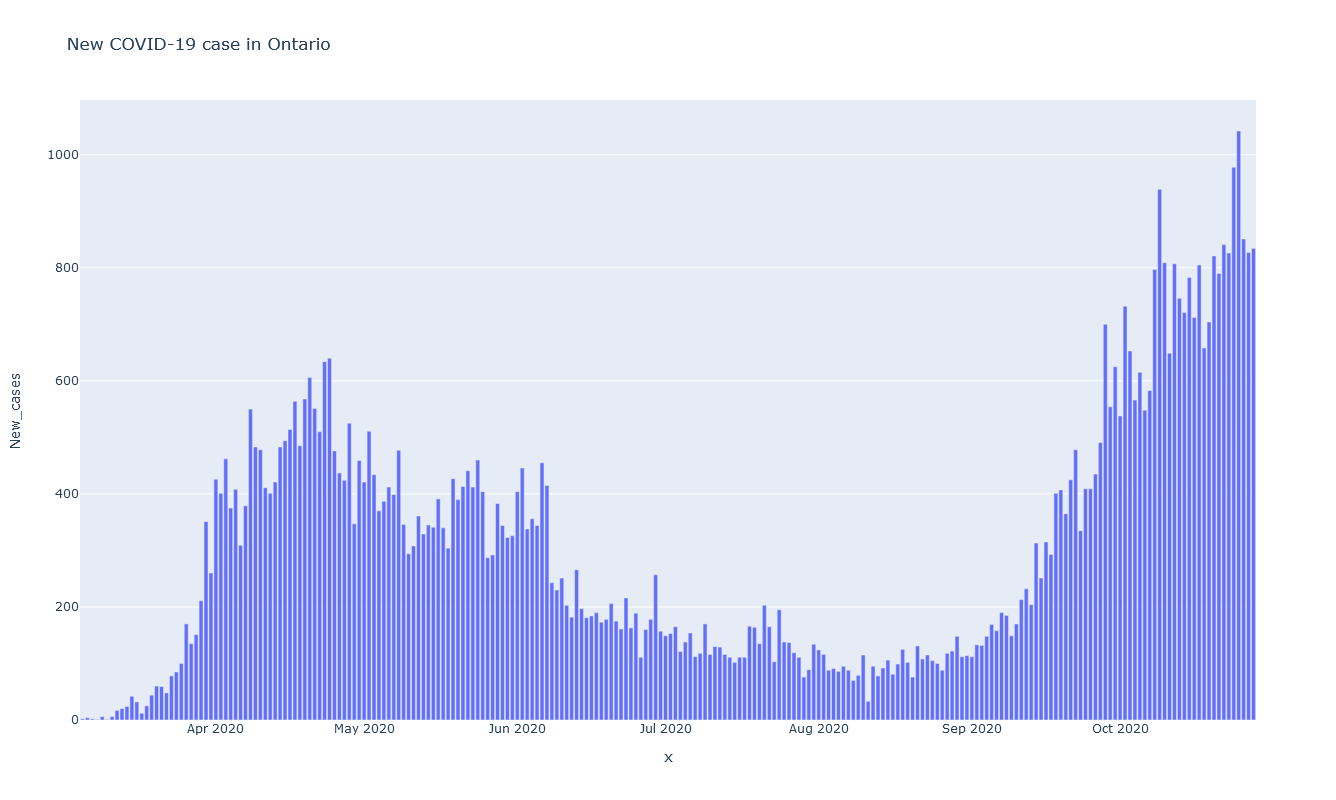

In [22]:
fig = px.bar(data_frame=Ontario_confirmed_df, x=Ontario_confirmed_df.index, y='New_cases', title='New COVID-19 case in Ontario', width=1400, height= 800)
fig.show()

## This chart is done using the standard Plotly library using the 'go.Figure' method. This was allows us to use multiple layers as illustrated-below

In [23]:
fig=go.Figure()
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_cases, name='Infections'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_deaths, name='Deaths'))
fig.add_trace(go.Scatter(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df.New_cases_MA7, name='7-Days rolling average'))
fig.update_layout(title='Daily new infections and deaths in Ontario', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)
py.plot(fig, filename='Covid-Ontario')


'https://plotly.com/~ralhusban/4/'

In [24]:
fig=go.Figure(skip_invalid=True)
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients hospitalized with COVID-19'], name='Hospitalizations'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients in ICU with COVID-19'], name='Patients in ICU'))
fig.add_trace(go.Bar(x=Ontario_confirmed_df.index, y=Ontario_confirmed_df['Number of patients in ICU on a ventilator with COVID-19'], name='Intubated'))
fig.update_layout(title='Onatario hospitalizations with COVID-19', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)
py.plot(fig, filename='Ontario_Covid19')


'https://plotly.com/~ralhusban/22/'

## A word of caution on both models attempted below: The Data that trained the model is very limited to produce a reliable model. Also a significant downside is that our only variable is the number of new infections. More advances and successful models take into account many variables such as how a population adheres to social distancing, the R^0 of the contagion, etc.

## Prophet (Built by Facebook). This library required your dataframe to have a date column called 'ds' and a 'y' column containing the numeric data you want to fit the model with. Hence we do some manipulations with our dataframe to make sure it fits the requirement.

In [25]:
test_df=Ontario_confirmed_df[['New_cases']] # Since the dataframe's index is the date, we only need the new cases column

In [26]:
test_df.rename(columns={'New_cases':'y'}, inplace=True)
test_df['ds']=test_df.index # Copied the index to the 'ds' date column as required by Prophet

C:\Users\amg_m\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## We initialize the Prophet forecasting procedure below. Notice that there are two growth options, logistic, and linear. The logistic growth did not fit the needs of an epidimiological model hence we opted for the default linear option while enabling the MCMC parameter (Markov Chain Monte Carlo) which allows us to include seasonal uncertanties and a full Baysian sampling.

In [27]:
m=Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, mcmc_samples=300) #Initiated a Prophet instance, and disabling all three parameters of seasonality

In [28]:
m.fit(test_df) # Model is fit with the dataframe e.g. trained

In [29]:
future=m.make_future_dataframe(periods=90) # A very useful function which builds a new dataframe with future dates to integrate the forcasted data. Here we chose to go 30 days into the future.

In [30]:
forecast = m.predict(future) # We initiated forecasting and passed the future dataframe as a parameter
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds         yhat   yhat_lower   yhat_upper
323 2021-01-22  2097.470769  1703.922992  2471.238909
324 2021-01-23  2111.194577  1703.570705  2500.199323
325 2021-01-24  2124.918386  1715.047374  2517.520881
326 2021-01-25  2138.642194  1719.256207  2552.421831
327 2021-01-26  2152.366002  1726.587415  2557.106305

In [31]:
forecast.head(-20)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0   2020-03-05   -40.587829  -133.109950    49.804083   -65.422648   
1   2020-03-06   -28.489584  -119.957567    57.687490   -52.445862   
2   2020-03-07   -16.391338  -108.716843    69.967166   -39.521917   
3   2020-03-08    -4.293092   -94.154277    89.815091   -26.783869   
4   2020-03-09     7.805154   -81.167895   100.023330   -13.887723   
..         ...          ...          ...          ...          ...   
303 2021-01-02  1822.994603  1557.755120  2086.184747  1567.192112   
304 2021-01-03  1836.718411  1550.489441  2104.360804  1574.241710   
305 2021-01-04  1850.442220  1572.730771  2124.276865  1582.805824   
306 2021-01-05  1864.166028  1574.438887  2154.667132  1591.972941   
307 2021-01-06  1877.889836  1589.576119  2161.093810  1598.718639   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     -15.862379             0.0                   0.0                   0.0   
1      -4.222789             0.0                   0.0                   0.0   
2       7.094851             0.0                   0.0                   0.0   
3      18.432153             0.0                   0.0                   0.0   
4      29.758995             0.0                   0.0                   0.0   
..           ...             ...                   ...                   ...   
303  2075.341094             0.0                   0.0                   0.0   
304  2094.585097             0.0                   0.0                   0.0   
305  2116.481865             0.0                   0.0                   0.0   
306  2135.678581             0.0                   0.0                   0.0   
307  2154.152358             0.0                   0.0                   0.0   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
303                   0.0                         0.0   
304                   0.0                         0.0   
305                   0.0                         0.0   
306                   0.0                         0.0   
307                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
0                           0.0   -40.587829  
1                           0.0   -28.489584  
2                           0.0   -16.391338  
3                           0.0    -4.293092  
4                           0.0     7.805154  
..                          ...          ...  
303                         0.0  1822.994603  
304                         0.0  1836.718411  
305                         0.0  1850.442220  
306                         0.0  1864.166028  
307                         0.0  1877.889836  

[308 rows x 13 columns]

## Below plot illustrates the actual data in purple dotted line while the solid lines represented the upper, lower, and mid y_hat (forecast) ranges generated by the Prophet.
## The sharp increase in cases and deaths on May 6th destabilized the model. This is caused by the NYT starting to report probable COVID-19 cases and deaths and not only the ones confirmed by testing.

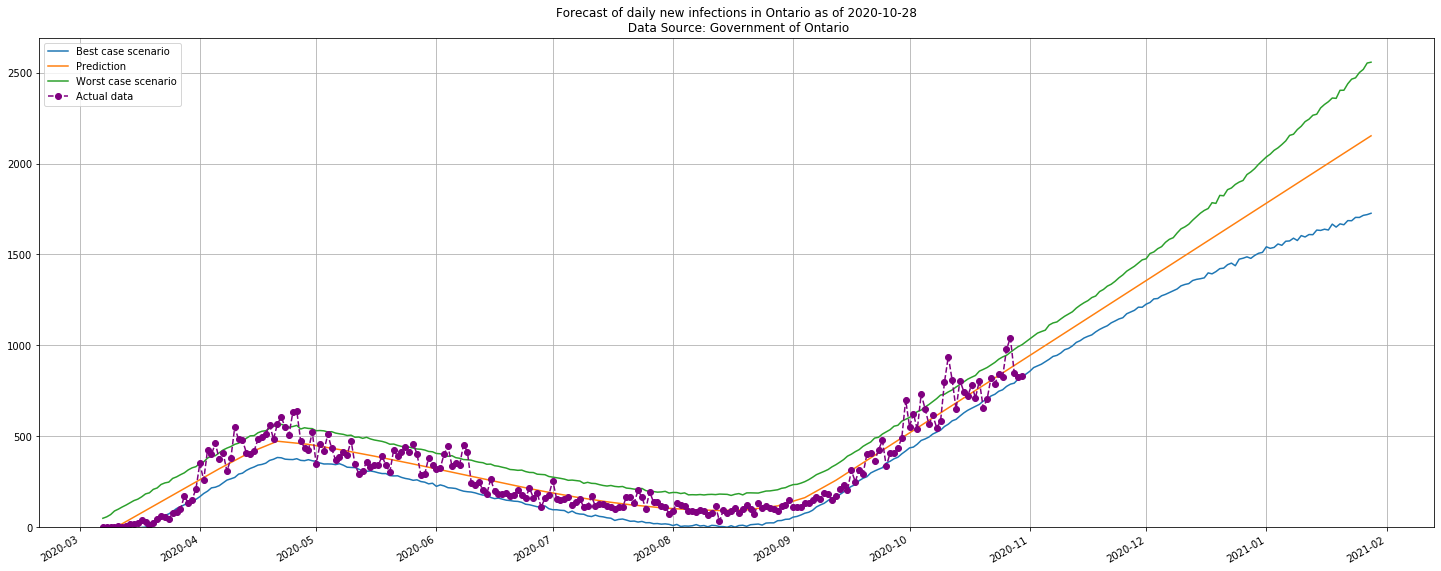

In [32]:
fig, ax=plt.subplots(figsize=(25,10))
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'), forecast.yhat_lower, label='Best case scenario')
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'),forecast.yhat, label='Prediction')
plt.plot(pd.date_range(start='2020-03-07', periods=len(forecast), freq='D'), forecast.yhat_upper, label='Worst case scenario')
plt.plot(pd.date_range(start='2020-03-07', periods=len(test_df), freq='D'), test_df.y,  'o--', label='Actual data', color='purple')
plt.title('Forecast of daily new infections in Ontario as of '+ str(dt.date.today()) + '\n Data Source: Government of Ontario')
plt.legend()
plt.grid()
#plt.hlines(y=0, xmin=0, xmax=len(future), color='red')
plt.ylim(bottom=0)
fig.autofmt_xdate()
plt.show()

## The below plot is built-in in the Prophet, it illustrates the same data

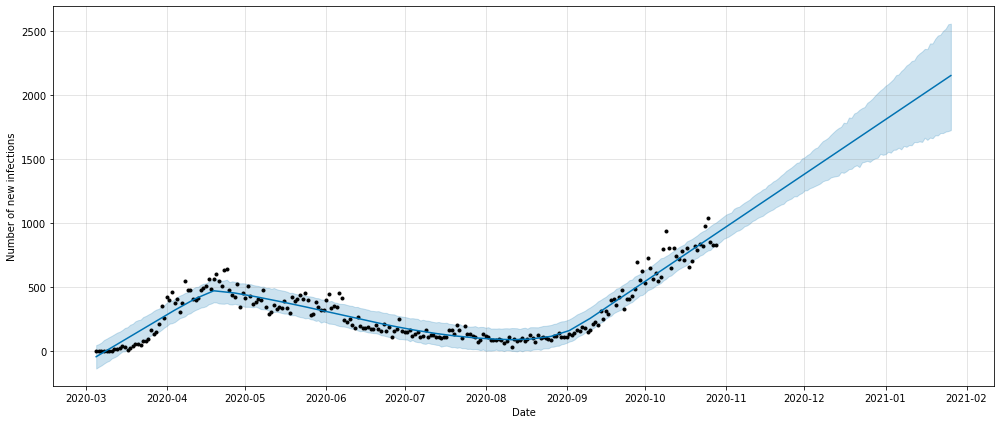

In [33]:
fig1=m.plot(forecast.iloc[:1500], figsize=(14,6), xlabel='Date', ylabel='Number of new infections')

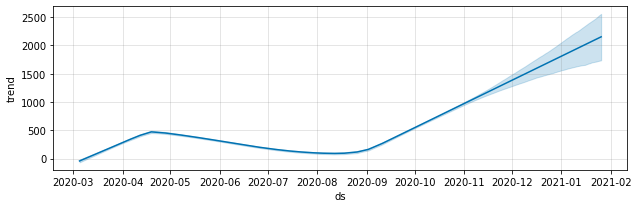

In [34]:
fig=m.plot_components(forecast)

In [35]:
Ontario_clinic_data.sort_values(by=['Accurate_Episode_Date'], ascending=True, inplace=True)
Ontario_clinic_data['Accurate_Episode_Date']=pd.to_datetime(Ontario_clinic_data.Accurate_Episode_Date)

In [36]:
Ontario_clinic_data

Row_ID Accurate_Episode_Date Case_Reported_Date Test_Reported_Date  \
16893   16894            2019-12-25         2020-03-29         2020-03-29   
33351   33352            2020-01-01         2020-05-17         2020-05-17   
27664   27665            2020-01-01         2020-04-24         2020-04-24   
37704   37705            2020-01-10         2020-06-10         2020-06-10   
14213   14214            2020-01-16         2020-10-08         2020-10-08   
...       ...                   ...                ...                ...   
72542   72543            2020-10-27         2020-10-27                NaN   
10798   10799            2020-10-27         2020-10-27         2020-10-27   
9134     9135            2020-10-27         2020-10-27         2020-10-27   
43711   43712                   NaT         2020-04-17         2020-04-17   
52221   52222                   NaT         2020-10-09         2020-10-09   

      Specimen_Date Age_Group Client_Gender Case_AcquisitionInfo  \
16893           NaN       70s          MALE    No known epi link   
33351           NaN       50s          MALE                   CC   
27664           NaN       80s          MALE    No known epi link   
37704           NaN       50s          MALE                   CC   
14213    2020-10-08       50s        FEMALE    No known epi link   
...             ...       ...           ...                  ...   
72542           NaN       <20          MALE                   CC   
10798    2020-10-27       20s          MALE  Missing Information   
9134     2020-10-26       <20        FEMALE  Missing Information   
43711    2020-04-15   UNKNOWN          MALE    No known epi link   
52221    2020-10-01   UNKNOWN   UNSPECIFIED    No known epi link   

           Outcome1 Outbreak_Related                       Reporting_PHU  \
16893      Resolved              NaN  York Region Public Health Services   
33351      Resolved              NaN   Region of Waterloo, Public Health   
27664      Resolved              NaN       Haldimand-Norfolk Health Unit   
37704      Resolved              NaN       Haldimand-Norfolk Health Unit   
14213      Resolved              NaN         Eastern Ontario Health Unit   
...             ...              ...                                 ...   
72542  Not Resolved              NaN     Hamilton Public Health Services   
10798  Not Resolved              NaN                  Peel Public Health   
9134   Not Resolved              NaN  York Region Public Health Services   
43711      Resolved              NaN               Toronto Public Health   
52221      Resolved              NaN               Toronto Public Health   

                Reporting_PHU_Address Reporting_PHU_City  \
16893              17250 Yonge Street          Newmarket   
33351          99 Regina Street South           Waterloo   
27664             12 Gilbertson Drive             Simcoe   
37704             12 Gilbertson Drive             Simcoe   
14213                1000 Pitt Street           Cornwall   
...                               ...                ...   
72542    110 King St. West, 2nd Floor           Hamilton   
10798          7120 Hurontario Street        Mississauga   
9134               17250 Yonge Street          Newmarket   
43711  277 Victoria Street, 5th Floor            Toronto   
52221  277 Victoria Street, 5th Floor            Toronto   

      Reporting_PHU_Postal_Code  \
16893                   L3Y 6Z1   
33351                   N2J 4V3   
27664                   N3Y 4N5   
37704                   N3Y 4N5   
14213                   K6J 5T1   
...                         ...   
72542                   L8P 4S6   
10798                   L5W 1N4   
9134                    L3Y 6Z1   
43711                   M5B 1W2   
52221                   M5B 1W2   

                                   Reporting_PHU_Website  \
16893           www.york.ca/wps/portal/yorkhome/health/    
33351                            www.regionofwaterloo.ca   
27664                         

In [37]:
Ontario_clinic_data['Outcome1'].mode()

0    Resolved
dtype: object

In [38]:
Ontario_clinic_data['Outcome1'].value_counts()

Resolved        62303
Not Resolved     7474
Fatal            3108
Name: Outcome1, dtype: int64

In [39]:
#Grouped_Ontario_Clinic_Data=Ontario_clinic_data.groupby(['Reporting_PHU','Reporting_PHU_Latitude', 'Reporting_PHU_Longitude', 'Outcome1'], ).agg(['count'])['Reporting_PHU_City'].sort_values(by=['Reporting_PHU'],ascending=True)
Grouped_Ontario_Clinic_Data=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Outcome1'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
Grouped_Ontario_Clinic_Data_case_source=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Case_AcquisitionInfo'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
Grouped_Ontario_Clinic_Data_age_group=Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Age_Group'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})

In [40]:
Grouped_Ontario_Clinic_Data

Reporting_PHU_City      Outcome1  Row_ID  Reporting_PHU_Latitude  \
0              Barrie         Fatal      47               44.410713   
1              Barrie  Not Resolved     125               44.410713   
2              Barrie      Resolved    1156               44.410713   
3          Belleville         Fatal       5               44.186674   
4          Belleville  Not Resolved       5               44.186674   
..                ...           ...     ...                     ...   
91             Whitby  Not Resolved     241               43.898605   
92             Whitby      Resolved    2491               43.898605   
93            Windsor         Fatal      77               42.308796   
94            Windsor  Not Resolved      43               42.308796   
95            Windsor      Resolved    2684               42.308796   

    Reporting_PHU_Longitude  
0                -79.686306  
1                -79.686306  
2                -79.686306  
3                -77.391446  
4                -77.391446  
..                      ...  
91               -78.940341  
92               -78.940341  
93               -83.033670  
94               -83.033670  
95               -83.033670  

[96 rows x 5 columns]

In [41]:
Grouped_Ontario_Clinic_Data_case_source

Reporting_PHU_City  Case_AcquisitionInfo  Row_ID  Reporting_PHU_Latitude  \
0               Barrie                    CC     536               44.410713   
1               Barrie   Missing Information      43               44.410713   
2               Barrie     No known epi link     367               44.410713   
3               Barrie                    OB     293               44.410713   
4               Barrie                Travel      82               44.410713   
..                 ...                   ...     ...                     ...   
177            Windsor   Missing Information       9               42.308796   
178            Windsor     No known epi link     463               42.308796   
179            Windsor                    OB    1469               42.308796   
180            Windsor                Travel     163               42.308796   
181            Windsor  Unspecified epi link       2               42.308796   

     Reporting_PHU_Longitude  
0                 -79.686306  
1                 -79.686306  
2                 -79.686306  
3                 -79.686306  
4                 -79.686306  
..                       ...  
177               -83.033670  
178               -83.033670  
179               -83.033670  
180               -83.033670  
181               -83.033670  

[182 rows x 5 columns]

In [42]:
Grouped_Ontario_Clinic_Data_age_group

Reporting_PHU_City Age_Group  Row_ID  Reporting_PHU_Latitude  \
0               Barrie       20s     269               44.410713   
1               Barrie       30s     214               44.410713   
2               Barrie       40s     181               44.410713   
3               Barrie       50s     191               44.410713   
4               Barrie       60s     138               44.410713   
..                 ...       ...     ...                     ...   
293            Windsor       60s     173               42.308796   
294            Windsor       70s      96               42.308796   
295            Windsor       80s      91               42.308796   
296            Windsor       90s      79               42.308796   
297            Windsor       <20     183               42.308796   

     Reporting_PHU_Longitude  
0                 -79.686306  
1                 -79.686306  
2                 -79.686306  
3                 -79.686306  
4                 -79.686306  
..                       ...  
293               -83.033670  
294               -83.033670  
295               -83.033670  
296               -83.033670  
297               -83.033670  

[298 rows x 5 columns]

In [43]:

unresolved_df=Grouped_Ontario_Clinic_Data[Grouped_Ontario_Clinic_Data.Outcome1=='Not Resolved'].sort_values(by='Row_ID', ascending=False)

In [44]:
unresolved_df.rename(columns={'Outcome1':'Status','Row_ID':'Qty'}, inplace=True)

In [45]:
unresolved_df.head(15)

Reporting_PHU_City        Status   Qty  Reporting_PHU_Latitude  \
85            Toronto  Not Resolved  2998               43.656591   
32        Mississauga  Not Resolved  1433               43.647471   
36          Newmarket  Not Resolved   960               44.048023   
45             Ottawa  Not Resolved   715               45.345665   
91             Whitby  Not Resolved   241               43.898605   
42           Oakville  Not Resolved   183               43.413997   
22           Hamilton  Not Resolved   137               43.257631   
16           Cornwall  Not Resolved   130               45.029152   
1              Barrie  Not Resolved   125               44.410713   
76            Thorold  Not Resolved    88               43.116537   
88           Waterloo  Not Resolved    79               43.462876   
19             Guelph  Not Resolved    67               43.524881   
7           Brantford  Not Resolved    54               43.151811   
29             London  Not Resolved    54               42.981468   
94            Windsor  Not Resolved    43               42.308796   

    Reporting_PHU_Longitude  
85               -79.379358  
32               -79.708893  
36               -79.480239  
45               -75.763912  
91               -78.940341  
42               -79.744796  
22               -79.871341  
16               -74.736298  
1                -79.686306  
76               -79.241220  
88               -80.520913  
19               -80.233743  
7                -80.274374  
29               -81.254016  
94               -83.033670

In [46]:
unresolved_df['Status'].astype('category').cat.codes.value_counts()

0    33
dtype: int64

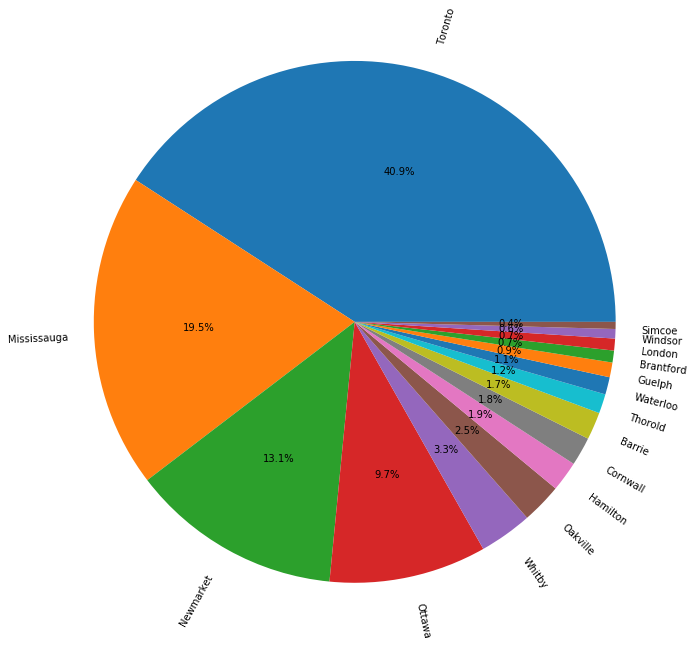

In [47]:
plt.pie(unresolved_df.Qty[unresolved_df.Qty>30], labels=unresolved_df.Reporting_PHU_City[unresolved_df.Qty>30], radius=3, rotatelabels=True, autopct='%1.1f%%')
plt.show()

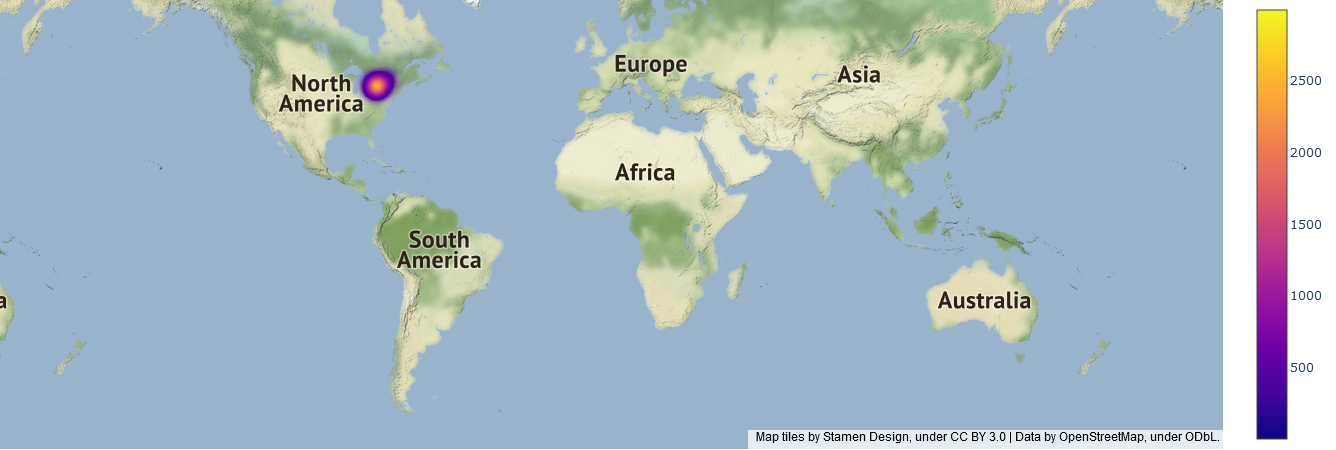

In [48]:
fig = go.Figure(go.Densitymapbox(lat=unresolved_df.Reporting_PHU_Latitude, lon=unresolved_df.Reporting_PHU_Longitude, z=unresolved_df.Qty,
                                 radius=20))
fig.update_layout(mapbox_style="stamen-terrain", mapbox_center_lon=3)
fig.update_layout(margin={"r":10,"t":0,"l":0,"b":1})
fig.show()

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



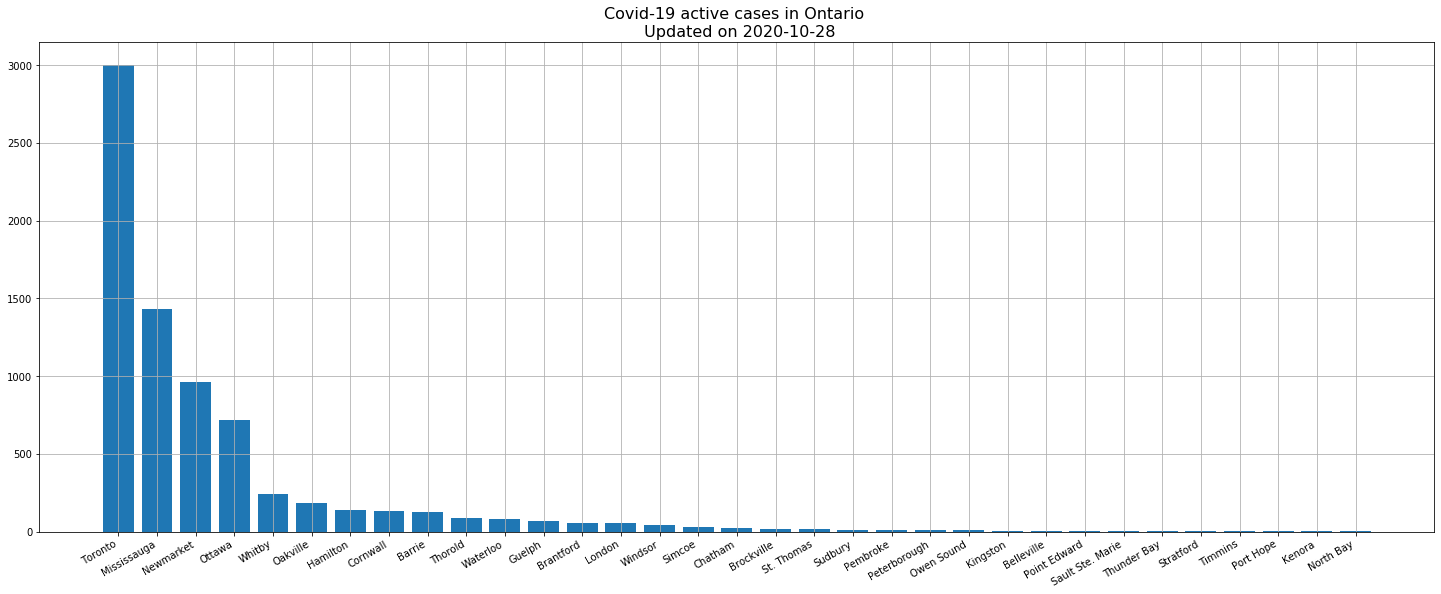

In [49]:
fig, ax=plt.subplots(figsize=(25,10))
plt.bar(unresolved_df.Reporting_PHU_City, unresolved_df.Qty)
fig.autofmt_xdate()
plt.grid()
plt.title('Covid-19 active cases in Ontario \n Updated on '+str(dt.date.today()), fontsize=16)
fig.show()



In [50]:
active_by_age_group=Grouped_Ontario_Clinic_Data_age_group.sort_values(by='Row_ID', ascending=False)

In [51]:
active_age_group_Toronto=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Toronto']
active_age_group_Missisauga=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Missisauga']
active_age_group_Ottawa=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Ottawa']
active_age_group_Oakville=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Oakville']
active_age_group_Hamilton=active_by_age_group[active_by_age_group.Reporting_PHU_City=='Hamilton']

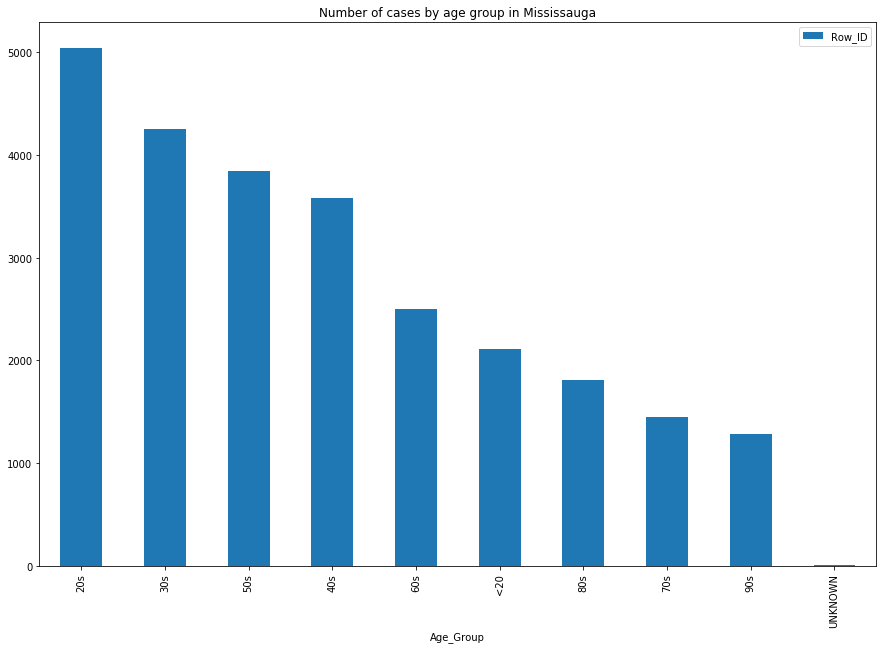

In [53]:
active_by_age_group[['Reporting_PHU_City','Age_Group','Row_ID']].groupby(['Reporting_PHU_City']).get_group('Toronto').plot(kind='bar', x='Age_Group', figsize=(15,10), title='Number of cases by age group in Mississauga')
#Ontario_clinic_data.groupby(['Reporting_PHU_City', 'Case_AcquisitionInfo'], as_index=False).agg({'Row_ID':'count', 'Reporting_PHU_Latitude':'last', 'Reporting_PHU_Longitude':'last'})
